In [3]:
# Clone the entire repo.
!git clone -l -s git://github.com/Idan707/Kaggle_TMDB_Box_Office_Prediction.git cloned-repo
%cd cloned-repo
# !ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (170/170), done.
remote: Total 206 (delta 107), reused 87 (delta 35), pack-reused 0
Receiving objects: 100% (206/206), 26.80 MiB | 7.69 MiB/s, done.
Resolving deltas: 100% (107/107), done.
/content/cloned-repo


In [2]:
#pip install pandas==0.25
pip install catboost

     |████████████████████████████████| 64.4MB 68kB/s 


# Import & Load

In [0]:
# imports
import pandas as pd
import  numpy as np
import ast
import json
import gensim
import datetime
import ast
import nltk
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from sklearn.preprocessing import MultiLabelBinarizer ,normalize
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
import lightgbm as lgb
import catboost as cat
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import GroupKFold
import xgboost as xgb
import warnings
import pickle as pkl
warnings.simplefilter(action='ignore', category=FutureWarning)

# set display
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.2f}'.format

# read raw data
train = pd.read_csv('/content/cloned-repo/Data/train.csv',
                    parse_dates=['release_date'])
test = pd.read_csv('/content/cloned-repo/Data/test.csv',
                    parse_dates=['release_date'])

# The data below comes from the kernel EDA, Feature Engineering, LGB+XGB+CAT of Kamal Chhirang
trainAdditionalFeatures = pd.read_csv('/content/cloned-repo/Data/TrainAdditionalFeatures.csv')[['imdb_id','popularity2','rating','totalVotes']]
testAdditionalFeatures = pd.read_csv('/content/cloned-repo/Data/TestAdditionalFeatures.csv')[['imdb_id','popularity2','rating','totalVotes']]

train = pd.merge(train, trainAdditionalFeatures, how='left', on=['imdb_id'])
test = pd.merge(test, testAdditionalFeatures, how='left', on=['imdb_id'])

# From https://www.kaggle.com/zero92/tmdb-prediction/data
release_dates = pd.read_csv('//content/cloned-repo/Data/release_dates_per_country.csv')
release_dates['id'] = range(1,7399)
release_dates.drop(['original_title','title'],axis = 1,inplace = True)
release_dates.index = release_dates['id']

release_dates.drop('id',axis = 1,inplace = True)
train = pd.merge(train, release_dates, how='left', on=['id'], left_index=False, right_index=True)
test = pd.merge(test, release_dates, how='left', on=['id'], left_index=False, right_index=True)

# Date Fix
train['release_date'] = train['release_date'].mask(train['release_date'].dt.year > 2017, 
                                                   train['release_date'] - pd.offsets.DateOffset(years=100))
test['release_date'] = test['release_date'].mask(test['release_date'].dt.year > 2017, 
                                                   test['release_date'] - pd.offsets.DateOffset(years=100))

test['revenue'] = 0
#train.index = train['id']
#test.index = test['id']

mlb = MultiLabelBinarizer()

In [0]:
train.loc[train['id'] == 16,'revenue'] = 192864         
train.loc[train['id'] == 90,'budget'] = 30000000                  
train.loc[train['id'] == 118,'budget'] = 60000000       
train.loc[train['id'] == 149,'budget'] = 18000000       
train.loc[train['id'] == 313,'revenue'] = 12000000       
train.loc[train['id'] == 451,'revenue'] = 12000000      
train.loc[train['id'] == 464,'budget'] = 20000000       
train.loc[train['id'] == 470,'budget'] = 13000000       
train.loc[train['id'] == 513,'budget'] = 930000         
train.loc[train['id'] == 797,'budget'] = 8000000        
train.loc[train['id'] == 819,'budget'] = 90000000       
train.loc[train['id'] == 850,'budget'] = 90000000       
train.loc[train['id'] == 1007,'budget'] = 2              
train.loc[train['id'] == 1112,'budget'] = 7500000       
train.loc[train['id'] == 1131,'budget'] = 4300000        
train.loc[train['id'] == 1359,'budget'] = 10000000       
train.loc[train['id'] == 1542,'budget'] = 1             
train.loc[train['id'] == 1570,'budget'] = 15800000       
train.loc[train['id'] == 1571,'budget'] = 4000000        
train.loc[train['id'] == 1714,'budget'] = 46000000       
train.loc[train['id'] == 1721,'budget'] = 17500000       
train.loc[train['id'] == 1865,'revenue'] = 25000000      
train.loc[train['id'] == 1885,'budget'] = 12             
train.loc[train['id'] == 2091,'budget'] = 10             
train.loc[train['id'] == 2268,'budget'] = 17500000       
train.loc[train['id'] == 2491,'budget'] = 6              
train.loc[train['id'] == 2602,'budget'] = 31000000       
train.loc[train['id'] == 2612,'budget'] = 15000000       
train.loc[train['id'] == 2696,'budget'] = 10000000      
train.loc[train['id'] == 2801,'budget'] = 10000000       
train.loc[train['id'] == 335,'budget'] = 2 
train.loc[train['id'] == 348,'budget'] = 12
train.loc[train['id'] == 470,'budget'] = 13000000 
train.loc[train['id'] == 513,'budget'] = 1100000
train.loc[train['id'] == 640,'budget'] = 6 
train.loc[train['id'] == 696,'budget'] = 1
train.loc[train['id'] == 797,'budget'] = 8000000 
train.loc[train['id'] == 850,'budget'] = 1500000
train.loc[train['id'] == 1199,'budget'] = 5 
train.loc[train['id'] == 1282,'budget'] = 9              
train.loc[train['id'] == 1347,'budget'] = 1
train.loc[train['id'] == 1755,'budget'] = 2
train.loc[train['id'] == 1801,'budget'] = 5
train.loc[train['id'] == 1918,'budget'] = 592 
train.loc[train['id'] == 2033,'budget'] = 4
train.loc[train['id'] == 2118,'budget'] = 344 
train.loc[train['id'] == 2252,'budget'] = 130
train.loc[train['id'] == 2256,'budget'] = 1 
train.loc[train['id'] == 2696,'budget'] = 10000000
test.loc[test['id'] == 3033,'budget'] = 250 
test.loc[test['id'] == 3051,'budget'] = 50
test.loc[test['id'] == 3084,'budget'] = 337
test.loc[test['id'] == 3224,'budget'] = 4  
test.loc[test['id'] == 3594,'budget'] = 25  
test.loc[test['id'] == 3619,'budget'] = 500  
test.loc[test['id'] == 3831,'budget'] = 3  
test.loc[test['id'] == 3935,'budget'] = 500  
test.loc[test['id'] == 4049,'budget'] = 995946 
test.loc[test['id'] == 4424,'budget'] = 3  
test.loc[test['id'] == 4460,'budget'] = 8  
test.loc[test['id'] == 4555,'budget'] = 1200000 
test.loc[test['id'] == 4624,'budget'] = 30 
test.loc[test['id'] == 4645,'budget'] = 500 
test.loc[test['id'] == 4709,'budget'] = 450 
test.loc[test['id'] == 4839,'budget'] = 7
test.loc[test['id'] == 3125,'budget'] = 25 
test.loc[test['id'] == 3142,'budget'] = 1
test.loc[test['id'] == 3201,'budget'] = 450
test.loc[test['id'] == 3222,'budget'] = 6
test.loc[test['id'] == 3545,'budget'] = 38
test.loc[test['id'] == 3670,'budget'] = 18
test.loc[test['id'] == 3792,'budget'] = 19
test.loc[test['id'] == 3881,'budget'] = 7
test.loc[test['id'] == 3969,'budget'] = 400
test.loc[test['id'] == 4196,'budget'] = 6
test.loc[test['id'] == 4221,'budget'] = 11
test.loc[test['id'] == 4222,'budget'] = 500
test.loc[test['id'] == 4285,'budget'] = 11
test.loc[test['id'] == 4319,'budget'] = 1
test.loc[test['id'] == 4639,'budget'] = 10
test.loc[test['id'] == 4719,'budget'] = 45
test.loc[test['id'] == 4822,'budget'] = 22
test.loc[test['id'] == 4829,'budget'] = 20
test.loc[test['id'] == 4969,'budget'] = 20
test.loc[test['id'] == 5021,'budget'] = 40 
test.loc[test['id'] == 5035,'budget'] = 1 
test.loc[test['id'] == 5063,'budget'] = 14 
test.loc[test['id'] == 5119,'budget'] = 2 
test.loc[test['id'] == 5214,'budget'] = 30 
test.loc[test['id'] == 5221,'budget'] = 50 
test.loc[test['id'] == 4903,'budget'] = 15
test.loc[test['id'] == 4983,'budget'] = 3
test.loc[test['id'] == 5102,'budget'] = 28
test.loc[test['id'] == 5217,'budget'] = 75
test.loc[test['id'] == 5224,'budget'] = 3 
test.loc[test['id'] == 5469,'budget'] = 20 
test.loc[test['id'] == 5840,'budget'] = 1 
test.loc[test['id'] == 5960,'budget'] = 30
test.loc[test['id'] == 6506,'budget'] = 11 
test.loc[test['id'] == 6553,'budget'] = 280
test.loc[test['id'] == 6561,'budget'] = 7
test.loc[test['id'] == 6582,'budget'] = 218
test.loc[test['id'] == 6638,'budget'] = 5
test.loc[test['id'] == 6749,'budget'] = 8 
test.loc[test['id'] == 6759,'budget'] = 50 
test.loc[test['id'] == 6856,'budget'] = 10
test.loc[test['id'] == 6858,'budget'] =  100
test.loc[test['id'] == 6876,'budget'] =  250
test.loc[test['id'] == 6972,'budget'] = 1
test.loc[test['id'] == 7079,'budget'] = 8000000
test.loc[test['id'] == 7150,'budget'] = 118
test.loc[test['id'] == 6506,'budget'] = 118
test.loc[test['id'] == 7225,'budget'] = 6
test.loc[test['id'] == 7231,'budget'] = 85
test.loc[test['id'] == 5222,'budget'] = 5
test.loc[test['id'] == 5322,'budget'] = 90
test.loc[test['id'] == 5350,'budget'] = 70
test.loc[test['id'] == 5378,'budget'] = 10
test.loc[test['id'] == 5545,'budget'] = 80
test.loc[test['id'] == 5810,'budget'] = 8
test.loc[test['id'] == 5926,'budget'] = 300
test.loc[test['id'] == 5927,'budget'] = 4
test.loc[test['id'] == 5986,'budget'] = 1
test.loc[test['id'] == 6053,'budget'] = 20
test.loc[test['id'] == 6104,'budget'] = 1
test.loc[test['id'] == 6130,'budget'] = 30
test.loc[test['id'] == 6301,'budget'] = 150
test.loc[test['id'] == 6276,'budget'] = 100
test.loc[test['id'] == 6473,'budget'] = 100
test.loc[test['id'] == 6842,'budget'] = 30

# Feature Engineering 

In [5]:
def convert_string_to_list(strVal):
    if type(strVal) is not str:
        return  []
    else:
        return ast.literal_eval(strVal)
    
def format_dict_column_and_extract_names(strVal, col="name"):
    listOfItems = convert_string_to_list(strVal)

    return list(map(lambda x: x[col], listOfItems))

def add_x_length_column(df, col):
    df[col + '_size'] = df[col].apply(lambda x: len(x))
    
    return df

def extract_genres(df):
    df['genres'] = df['genres'].apply(format_dict_column_and_extract_names)
    df = add_x_length_column(df, col='genres')
    temp = mlb.fit_transform(df.pop('genres'))
    temp_df = pd.DataFrame(temp, columns=list(map(lambda x: 'genres'+'_'+x,mlb.classes_)), 
                              )#index=temp.index)
    #print('extract_genres temp df shape: ', temp_df.shape)
    df = pd.merge(df, temp_df, how='inner', on=df.id)
    
    return df

def extract_common(df, col, limit, apply_dict_to_col=True):
    if apply_dict_to_col == True:
        df[col] = df[col].apply(format_dict_column_and_extract_names)
        
    companiesCount = df[col].apply(pd.Series).stack().value_counts().sort_values(axis=0, ascending=False)
    companiesToKeep = companiesCount[:limit].keys()
    
    add_x_length_column(df, col)
    df[col] = df[col].apply(lambda x: list(filter(lambda i: i in companiesToKeep, x)))
    
    temp = mlb.fit_transform(df.pop(col))
    temp_df = pd.DataFrame(temp, columns=list(map(lambda x: col+'_'+x,mlb.classes_)), 
                              )#index=temp.index)
    #print('extract_common temp df shape: ', temp_df.shape)
    #print('temp index: ',temp_df.index)
    df = pd.merge(df, temp_df, how='inner', left_index=True, right_index=True)

    return df

def last_year_metrics(df, agg_col='release_date_Year', calc_col=['revenue','imdb_id','popularity','budget'], leg=1):
    
    temp = df.groupby([agg_col]).agg(last_period_mean_revenue = (calc_col[0], 'mean'),
                                     last_period_median_revenue = (calc_col[0], 'median'),
                                     last_period_movies_count = (calc_col[1], 'count'),
                                     last_period_mean_popularity = (calc_col[2], 'mean'),
                                     last_period_median_popularity = (calc_col[2], 'median'),
                                     last_period_mean_budget = (calc_col[3], 'mean'),
                                     last_period_median_budget = (calc_col[3], 'median')).shift(leg).reset_index()

    return pd.merge(df, temp, on=['release_date_Year'], how='left')

def days_diff_from_last_movie(df, col='release_date'):#see if there is a need in buckts
    df = df.sort_values(by=[col])
    df['days_diff_from_last_movie'] = df[col].diff().fillna(pd.Timedelta(seconds=0)).dt.days
    
    return df

def ratios(df):
    df['budget_to_runtime'] = df['budget']/df['runtime']
    df['budget_to_cast_crew_size'] = df['budget']/(df['cast_size'] + df['crew_size'])
    df['budget_to_popularity'] = df['budget']/df['popularity']
    
    df['budget_to_year'] = df['budget'] / df['release_date_Year']
    df['budget_to_popularity_to_log_budget'] = df['budget_to_popularity'] / df['log_budget']
    df['year_to_log_budget'] = df['release_date_Year'] / df['log_budget']
    df['budget_to_runtime_to_year'] = df['budget_to_runtime'] / df['release_date_Year']
    
    return df

def add_datepart(df,col ='release_date'):
    df[col] = pd.to_datetime(df[col])
    df[col +'_Year']  = df[col].dt.year
    df[col +'_Month'] = df[col].dt.month
    df[col +'_day_of_month'] = df[col].dt.day
    df[col +'_week_day'] = df[col].dt.dayofweek
    df[col +'_is_quarter_start'] = df[col].dt.is_quarter_start
    df[col +'_is_quarter_start'] = df[col +'_is_quarter_start'].fillna(False)
    
    return df 

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
            
    return result

def extract_common_overview_words(df, col):
    df[col] = df[col].fillna('').astype(str).map(preprocess)
    df[col] = df[col].map(lambda x: list(set(x)))
    df = extract_common(df, col, limit=15, apply_dict_to_col=False)
    
    return df
  
def extract_gender(strVal, dict_key, dict_value):
    listOfItems = convert_string_to_list(strVal)

    Item = (list(filter(lambda lst: lst[dict_key] == dict_value, listOfItems)) or [None])[0]
    if type(Item) is dict:
        return Item['gender']
    else:
        return None
      
def add_gender(df, col, dict_key_in , dict_value_in):
    df[dict_key_in + '_' + str(dict_value_in) + '_gender'] = df[col].apply(extract_gender, args=[dict_key_in, dict_value_in])
    df[dict_key_in + '_' + str(dict_value_in) + '_gender'] = df[dict_key_in + '_' + str(dict_value_in) + '_gender'].fillna(2).astype('int64')
    
    return df

def std_avg_features(df, agg_col, calc_col):
    temp = df.groupby([agg_col], as_index=True).agg(mean_pop = (calc_col, 'mean'),
                                                    std_pop = (calc_col, 'std')).fillna(0)

    df = df.merge(temp, 'left', on=agg_col)
    df['zscore_pop_year'] = (df[calc_col] - df['mean_pop'])/ df['std_pop']
    df['zscore_pop_year'] = df['zscore_pop_year'].apply(abs).fillna(0)
    
    return df


def run_main(train, test):

  test['train_test'] = 'test'  
  train['train_test'] = 'train'

  # work on full df
  print('working on full df..')
  df = pd.concat([train, test],axis=0, sort=True)
  df = extract_genres(df)
  df = extract_common(df, col='production_companies', limit=10)
  df = extract_common(df, col='production_countries', limit=10)
  df = extract_common(df, col='spoken_languages', limit=10)
  df = extract_common(df, col='Keywords', limit=10)
  
  df = add_gender(df, col='crew', dict_key_in='job', dict_value_in='Producer')
  df = add_gender(df, col='crew', dict_key_in='job', dict_value_in='Director')
  df = add_gender(df, col='cast', dict_key_in='order', dict_value_in=0)
  df = add_gender(df, col='cast', dict_key_in='order', dict_value_in=1)
  df = extract_common(df, col='cast', limit=10)
  df = extract_common(df, col='crew', limit=10)

  # fill missing values 1
  print('fill missing values 1...')
  df['cast_size'] = np.where(df['cast_size'] == 0, df['cast_size'].mean(), df['cast_size'])
  df['crew_size'] = np.where(df['crew_size'] == 0, df['crew_size'].mean(), df['crew_size'])
  
  # add datepart
  print('add datepart...')
  df = add_datepart(df,col = 'release_date') 

  # add std avg zscore features
  print('add zscore features...')
  df = std_avg_features(df, agg_col='release_date_Year', calc_col='popularity')

  # split for data leak prevention
  print('split for data leak prevention and run main...')
  train = df[df['train_test'] == 'train']
  test = df[df['train_test'] == 'test']

  train = last_year_metrics(train)
  train = days_diff_from_last_movie(train)
  train['revenue'] = np.where(train['revenue'] == 0, train['last_period_median_revenue'], train['revenue'])
  train['revenue'] = np.where(train['revenue'] == 0, train["revenue"].mean(), train['revenue'])
  train = extract_common_overview_words(train, col='overview')

  test = last_year_metrics(test)
  test = days_diff_from_last_movie(test)
  test['revenue'] = np.where(test['revenue'] == 0, test['last_period_median_revenue'], test['revenue'])
  test['revenue'] = np.where(test['revenue'] == 0, test["revenue"].mean(), test['revenue'])
  test = extract_common_overview_words(test, col='overview')

  # addtion by https://www.kaggle.com/artgor/eda-feature-engineering-and-model-interpretation
  train['log_budget'] = np.log1p(train['budget'])
  test['log_budget'] = np.log1p(test['budget'])
  train['has_homepage'] = 0
  train.loc[train['homepage'].isnull() == False, 'has_homepage'] = 1
  test['has_homepage'] = 0
  test.loc[test['homepage'].isnull() == False, 'has_homepage'] = 1
  df['isMovieReleased'] = 1
  df.loc[ df['status'] != "Released" ,"isMovieReleased"] = 0

  df = pd.concat([train, test],axis=0, sort=True)
  # end addion

  # fill missing values 2
  print('fill missing values 2...')
  df['budget'] = np.where(df['budget'] == 0, df['last_period_median_budget'], df['budget'])
  df['budget'] = np.where(df['budget'] == 0, df["budget"].mean(), df['budget'])
  df['production_companies_size'] = np.where(df['production_companies_size'] == 0, df["production_companies_size"].mean(), df['production_companies_size'])
  df['production_countries_size'] = np.where(df['production_countries_size'] == 0, df["production_countries_size"].mean(), df['production_countries_size'])
  df['Keywords_size'] = np.where(df['Keywords_size'] == 0, df["Keywords_size"].mean(), df['Keywords_size'])

  # run ratios
  print('run ratios...')
  df = ratios(df)

  # fill missing values 3
  print('fill missing values 3...')
  df = df.replace([np.inf, -np.inf], np.nan)
  df['budget_to_runtime'] = np.where(df['budget_to_runtime'] == np.nan, df["budget_to_runtime"].mean(), df['budget_to_runtime'])
  df['belongs_to_collection_bool'] = np.where(df['belongs_to_collection'].isna(), 0, 1)
  df.drop(['belongs_to_collection'], axis=1, inplace=True)
  df["budget_to_popularity"] = np.where(df['budget_to_popularity'] == np.nan, df["budget_to_popularity"].mean(), df['budget_to_popularity'])

  # counting the numbers of words in the movie title 
  print('counting the numbers of words in the movie title..')
  df['original_title_words'] = df.original_title.str.split()
  df['original_title_words'] = df['original_title_words'].apply(lambda x: len(x))

  df = pd.get_dummies(df, prefix=['job_Producer_gender', 'job_Director_gender', 'order_0_gender', 'order_1_gender'], 
                          columns=['job_Producer_gender', 'job_Director_gender', 'order_0_gender', 'order_1_gender'])

  # removing highly correlated features
  print('removing highly correlated features...')
  df.drop(["release_date_Year", "genres_TV Movie", "last_period_mean_revenue", 
           'last_period_median_revenue', 'overview_wife', 'overview_year'], inplace=True, axis=1)

  # normalize features
  #scaler = preprocessing.power_transform()
  df["budget_to_popularity"] = preprocessing.power_transform(df[["budget_to_popularity"]])

  return df

df = run_main(train, test)
df.head()

working on full df..
fill missing values 1...
add datepart...
add zscore features...
split for data leak prevention and run main...
fill missing values 2...
run ratios...
fill missing values 3...
counting the numbers of words in the movie title..
removing highly correlated features...


,AR,AT,AU,BE,BG,CA,CL,CZ,DE,DK,FI,FR,GB,GR,HK,HU,ID,IE,IL,IS,IT,KW,KZ,Keywords_aftercreditsstinger,Keywords_based on novel,Keywords_duringcreditsstinger,Keywords_independent film,Keywords_love,Keywords_murder,Keywords_revenge,Keywords_sex,Keywords_size,Keywords_violence,Keywords_woman director,LV,MX,NL,NO,PE,PL,PT,RU,SE,SI,SK,TH,TR,TW,UA,US,budget,cast_Bruce Willis,cast_Liam Neeson,cast_Matt Damon,cast_Morgan Freeman,cast_Nicolas Cage,cast_Robert De Niro,cast_Samuel L. Jackson,cast_Steve Buscemi,cast_Sylvester Stallone,cast_Willem Dafoe,cast_size,crew_Avy Kaufman,crew_Bob Weinstein,crew_Deborah Aquila,crew_Hans Zimmer,crew_Harvey Weinstein,crew_James Newton Howard,crew_Mary Vernieu,crew_Robert Rodriguez,crew_Steven Spielberg,crew_Tricia Wood,crew_size,days_diff_from_last_movie,genres_Action,genres_Adventure,genres_Animation,genres_Comedy,genres_Crime,genres_Documentary,genres_Drama,genres_Family,genres_Fantasy,genres_Foreign,genres_History,genres_Horror,genres_Music,genres_Mystery,genres_Romance,genres_Science Fiction,genres_Thriller,genres_War,genres_Western,genres_size,has_homepage,homepage,id,imdb_id,key_0,last_period_mean_budget,last_period_mean_popularity,last_period_median_budget,last_period_median_popularity,last_period_movies_count,log_budget,mean_pop,movie_id,original_language,original_title,overview_family,overview_father,overview_film,overview_finds,overview_friends,overview_help,overview_life,overview_love,overview_size,overview_story,overview_time,overview_woman,overview_world,overview_years,overview_young,popularity,popularity2,poster_path,production_companies_Columbia Pictures,production_companies_Columbia Pictures Corporation,production_companies_Metro-Goldwyn-Mayer (MGM),production_companies_New Line Cinema,production_companies_Paramount Pictures,production_companies_Touchstone Pictures,production_companies_Twentieth Century Fox Film Corporation,production_companies_Universal Pictures,production_companies_Walt Disney Pictures,production_companies_Warner Bros.,production_companies_size,production_countries_Australia,production_countries_Canada,production_countries_France,production_countries_Germany,production_countries_India,production_countries_Italy,production_countries_Japan,production_countries_Spain,production_countries_United Kingdom,production_countries_United States of America,production_countries_size,rating,release_date,release_date_Month,release_date_day_of_month,release_date_is_quarter_start,release_date_week_day,release_year,revenue,runtime,spoken_languages_,spoken_languages_Deutsch,spoken_languages_English,spoken_languages_Español,spoken_languages_Français,spoken_languages_Italiano,spoken_languages_Pусский,spoken_languages_size,spoken_languages_हिन्दी,spoken_languages_日本語,spoken_languages_普通话,status,std_pop,tagline,theatrical,theatrical_limited,title,totalVotes,train_test,zscore_pop_year,budget_to_runtime,budget_to_cast_crew_size,budget_to_popularity,budget_to_year,budget_to_popularity_to_log_budget,year_to_log_budget,budget_to_runtime_to_year,belongs_to_collection_bool,original_title_words,job_Producer_gender_0,job_Producer_gender_1,job_Producer_gender_2,job_Director_gender_0,job_Director_gender_1,job_Director_gender_2,order_0_gender_0,order_0_gender_1,order_0_gender_2,order_1_gender_0,order_1_gender_1,order_1_gender_2
1763,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0,0,0,0,0,0,0,0,14.00,0,0,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,250000.00,0,0,0,0,0,0,0,0,0,0,35.00,0,0,0,0,0,0,0,0,0,0,12.00,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,NaN,1764,tt0012349,1764,nan,nan,nan,nan,nan,12.43,8.17,826.00,en,The Kid,0,0,0,0,0,0,0,0,28,0,0,0,1,0,0,8.17,8.66,/drgMcyTsySQBnUPGaBThCHGdlWT.jpg,0,0,0,0,0,0,0,0,0,0,2.00,0,0,0,0,0,0,0,0,0,1,1.00,8.20,1921-01-21,1.00,21.00,False,4.00,1957.00,2500000.00,68.00,0,0,0,0,0,0,0,1,0,0,0,Released,0.00,6 reels of Joy.,12.00,1.00,The Kid,760.00,train,0.00,3676.47,

# Modeling

In [0]:
model_df = df.copy()
model_df = model_df.drop(["homepage", "imdb_id", "movie_id", "original_language", "original_title", "poster_path", "release_date", "status", "tagline", "title", "key_0"], axis=1)

train = model_df[model_df['train_test'] == 'train']
test = model_df[model_df['train_test'] == 'test']

train = train.drop(['train_test'],axis=1)
test = test.drop(['train_test'] ,axis=1)

def score(data, y):
    validation_res = pd.DataFrame(
    {"id": data["id"].values,
     "transactionrevenue": data["revenue"].values,
     "predictedrevenue": np.expm1(y)}) 
    validation_res = validation_res.groupby("id")["transactionrevenue", "predictedrevenue"].sum().reset_index()

    return  np.sqrt(mean_squared_error((np.log1p(validation_res["transactionrevenue"].values)), 
                                     (np.log1p(validation_res["predictedrevenue"].values))))
    
class KFoldValidation():
    def __init__(self, data, n_splits=5):
        unique_vis = np.array(sorted(data['id'].astype(str).unique()))
        folds = GroupKFold(n_splits)
        ids = np.arange(data.shape[0])
        
        self.fold_ids = []
        for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
            self.fold_ids.append([
                    ids[data['id'].astype(str).isin(unique_vis[trn_vis])],
                    ids[data['id'].astype(str).isin(unique_vis[val_vis])]
                ])
            
    def validate(self, train, test, features, model, name="", prepare_stacking=False, 
                 fit_params={"early_stopping_rounds": 500, "verbose": 1000, "eval_metric": "rmse"}):
        model.FI = pd.DataFrame(index=features)
        full_score = 0
        
        if prepare_stacking:
            test[name] = 0
            train[name] = np.NaN
        
        for fold_id, (trn, val) in enumerate(self.fold_ids):
            devel = train[features].iloc[trn]
            y_devel = np.log1p(train["revenue"].iloc[trn])
            valid = train[features].iloc[val]
            y_valid = np.log1p(train["revenue"].iloc[val])
                       
            print("Fold ", fold_id, ":")
            model.fit(devel, y_devel, eval_set=[(valid, y_valid)], **fit_params)
            
            if len(model.feature_importances_) == len(features):  # some bugs in catboost?
                model.FI['fold' + str(fold_id)] = model.feature_importances_ / model.feature_importances_.sum()

            predictions = model.predict(valid)
            predictions[predictions < 0] = 0
            print("Fold ", fold_id, " error: ", mean_squared_error(y_valid, predictions)**0.5)
            
            fold_score = score(train.iloc[val], predictions)
            full_score += fold_score / len(self.fold_ids)
            print("Fold ", fold_id, " score: ", fold_score)
            
            if prepare_stacking:
                train[name].iloc[val] = np.expm1(predictions)
                
                test_predictions = model.predict(test[features])
                #print(test_predictions)
                test_predictions[test_predictions < 0] = 0
                test[name] += np.expm1(test_predictions) / len(self.fold_ids)
                
        print("Final rmsle score: ", full_score)
        return full_score


## Models config

In [0]:
lgbmodel = lgb.LGBMRegressor(n_estimators=20000, 
                             objective='regression', 
                             metric='rmse',
                             max_depth = 15,
                             num_leaves=30, 
                             min_child_samples=100,
                             learning_rate=0.001,
                             boosting = 'gbdt',
                             min_data_in_leaf= 10,
                             feature_fraction = 0.2,
                             bagging_freq = 1,
                             bagging_fraction = 0.9,
                             importance_type='gain',
                             lambda_l1 = 0.2,
                             bagging_seed=42, 
                             subsample=.8, 
                             colsample_bytree=.9,
                             use_best_model=True)

xgbmodel = xgb.XGBRegressor(max_depth=10, 
                            learning_rate=0.01, 
                            n_estimators=20000, 
                            objective='reg:linear', 
                            gamma=1.45, 
                            seed=42, 
                            silent=True,
                            subsample=0.7, 
                            colsample_bytree=0.8, 
                            colsample_bylevel=0.50)

catmodel = cat.CatBoostRegressor(iterations=5000, 
                                 learning_rate=0.01, 
                                 depth=6,
                                 loss_function = "RMSE",
                                 boost_from_average = True,
                                 colsample_bylevel=0.8,
                                 bagging_temperature = 0.2,
                                 metric_period = None,
                                 random_seed=2345,
                                 l2_leaf_reg = 0.2)

In [0]:
Kfolder = KFoldValidation(train)

In [9]:
Kfolder.validate(train, test, train.columns.drop(['revenue','id']) , lgbmodel, name="lgbfinal", prepare_stacking=True) 

Fold  0 :
Training until validation scores don't improve for 500 rounds.
[1000]	valid_0's rmse: 2.42773
[2000]	valid_0's rmse: 2.22998
[3000]	valid_0's rmse: 2.16538
[4000]	valid_0's rmse: 2.13592
[5000]	valid_0's rmse: 2.1193
[6000]	valid_0's rmse: 2.10939
[7000]	valid_0's rmse: 2.10317
[8000]	valid_0's rmse: 2.09892
[9000]	valid_0's rmse: 2.09638
[10000]	valid_0's rmse: 2.09454
[11000]	valid_0's rmse: 2.09302
[12000]	valid_0's rmse: 2.09185
Early stopping, best iteration is:
[12484]	valid_0's rmse: 2.09145
Fold  0  error:  2.091446685213491
Fold  0  score:  2.091446685213491


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Fold  1 :
Training until validation scores don't improve for 500 rounds.
[1000]	valid_0's rmse: 2.05699
[2000]	valid_0's rmse: 1.83007
[3000]	valid_0's rmse: 1.75497
[4000]	valid_0's rmse: 1.72228
[5000]	valid_0's rmse: 1.70384
[6000]	valid_0's rmse: 1.69253
[7000]	valid_0's rmse: 1.68546
[8000]	valid_0's rmse: 1.68025
[9000]	valid_0's rmse: 1.67642
[10000]	valid_0's rmse: 1.67383
[11000]	valid_0's rmse: 1.67209
[12000]	valid_0's rmse: 1.67062
[13000]	valid_0's rmse: 1.67007
[14000]	valid_0's rmse: 1.66964
[15000]	valid_0's rmse: 1.66923
Early stopping, best iteration is:
[15224]	valid_0's rmse: 1.66898
Fold  1  error:  1.6689845983139544
Fold  1  score:  1.6689845983139544


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Fold  2 :
Training until validation scores don't improve for 500 rounds.
[1000]	valid_0's rmse: 2.09196
[2000]	valid_0's rmse: 1.79749
[3000]	valid_0's rmse: 1.69455
[4000]	valid_0's rmse: 1.6523
[5000]	valid_0's rmse: 1.62944
[6000]	valid_0's rmse: 1.61655
[7000]	valid_0's rmse: 1.60915
[8000]	valid_0's rmse: 1.60511
[9000]	valid_0's rmse: 1.60278
[10000]	valid_0's rmse: 1.60156
[11000]	valid_0's rmse: 1.60112
[12000]	valid_0's rmse: 1.60073
[13000]	valid_0's rmse: 1.60039
Early stopping, best iteration is:
[12801]	valid_0's rmse: 1.60033
Fold  2  error:  1.6003329649102775
Fold  2  score:  1.6003329649102775


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Fold  3 :
Training until validation scores don't improve for 500 rounds.
[1000]	valid_0's rmse: 2.00103
[2000]	valid_0's rmse: 1.71492
[3000]	valid_0's rmse: 1.63298
[4000]	valid_0's rmse: 1.60341
[5000]	valid_0's rmse: 1.58929
[6000]	valid_0's rmse: 1.58189
[7000]	valid_0's rmse: 1.57767
[8000]	valid_0's rmse: 1.57503
[9000]	valid_0's rmse: 1.57357
[10000]	valid_0's rmse: 1.57272
Early stopping, best iteration is:
[9918]	valid_0's rmse: 1.57262
Fold  3  error:  1.5726157570599189
Fold  3  score:  1.5726157570599189


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Fold  4 :
Training until validation scores don't improve for 500 rounds.
[1000]	valid_0's rmse: 2.39383
[2000]	valid_0's rmse: 2.17108
[3000]	valid_0's rmse: 2.09954
[4000]	valid_0's rmse: 2.06913
[5000]	valid_0's rmse: 2.05165
[6000]	valid_0's rmse: 2.04222
[7000]	valid_0's rmse: 2.03525
[8000]	valid_0's rmse: 2.03039
[9000]	valid_0's rmse: 2.02737
[10000]	valid_0's rmse: 2.02622
[11000]	valid_0's rmse: 2.02512
[12000]	valid_0's rmse: 2.02395
[13000]	valid_0's rmse: 2.02349
[14000]	valid_0's rmse: 2.02316
Early stopping, best iteration is:
[14304]	valid_0's rmse: 2.02297
Fold  4  error:  2.0229741190455948
Fold  4  score:  2.022974119045595


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Final rmsle score:  1.7912708249086475


1.7912708249086475

In [10]:
Kfolder.validate(train, test, train.columns.drop(['revenue','id']), xgbmodel, name="xgbfinal", prepare_stacking=True)

Fold  0 :
[0]	validation_0-rmse:15.5541
Will train until validation_0-rmse hasn't improved in 500 rounds.
Stopping. Best iteration:
[456]	validation_0-rmse:2.16123

Fold  0  error:  2.1612286678001538
Fold  0  score:  2.1612286678001538


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Fold  1 :
[0]	validation_0-rmse:15.5627
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:1.7341
Stopping. Best iteration:
[655]	validation_0-rmse:1.7268

Fold  1  error:  1.7268040940146825
Fold  1  score:  1.7268040940146825


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Fold  2 :
[0]	validation_0-rmse:15.5236
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:1.6985
Stopping. Best iteration:
[527]	validation_0-rmse:1.69233

Fold  2  error:  1.6923269596361006
Fold  2  score:  1.6923269596361006


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Fold  3 :
[0]	validation_0-rmse:15.7838
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:1.68312
Stopping. Best iteration:
[718]	validation_0-rmse:1.68055

Fold  3  error:  1.6805521223853273
Fold  3  score:  1.6805521223853273


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Fold  4 :
[0]	validation_0-rmse:15.6398
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:2.11394
Stopping. Best iteration:
[508]	validation_0-rmse:2.10178

Fold  4  error:  2.1017782918995134
Fold  4  score:  2.1017782918995134


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Final rmsle score:  1.8725380271471554


1.8725380271471554

In [11]:
Kfolder.validate(train, test, train.columns.drop(['revenue','id']) , catmodel, name="catfinal", prepare_stacking=True,
               fit_params={"use_best_model": True, "verbose": 1000})

Fold  0 :
0:	learn: 2.9884834	test: 3.1380037	best: 3.1380037 (0)	total: 55.4ms	remaining: 4m 37s
1000:	learn: 1.2903732	test: 2.1237775	best: 2.1144909 (482)	total: 4.48s	remaining: 17.9s
2000:	learn: 0.9014597	test: 2.1242427	best: 2.1144909 (482)	total: 8.81s	remaining: 13.2s
3000:	learn: 0.6555509	test: 2.1271896	best: 2.1144909 (482)	total: 13.2s	remaining: 8.79s
4000:	learn: 0.4904555	test: 2.1303280	best: 2.1144909 (482)	total: 17.6s	remaining: 4.38s
4999:	learn: 0.3729694	test: 2.1294021	best: 2.1144909 (482)	total: 21.9s	remaining: 0us

bestTest = 2.114490853
bestIteration = 482

Shrink model to first 483 iterations.
Fold  0  error:  2.1144908714613515
Fold  0  score:  2.1144908714613515
Fold  1 :


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


0:	learn: 3.0708365	test: 2.8124810	best: 2.8124810 (0)	total: 7.99ms	remaining: 40s
1000:	learn: 1.3763952	test: 1.7099171	best: 1.7035194 (359)	total: 4.25s	remaining: 17s
2000:	learn: 0.9485490	test: 1.7179885	best: 1.7035194 (359)	total: 8.49s	remaining: 12.7s
3000:	learn: 0.6777755	test: 1.7195929	best: 1.7035194 (359)	total: 12.7s	remaining: 8.48s
4000:	learn: 0.5043170	test: 1.7216193	best: 1.7035194 (359)	total: 17s	remaining: 4.25s
4999:	learn: 0.3853940	test: 1.7229794	best: 1.7035194 (359)	total: 21.3s	remaining: 0us

bestTest = 1.703519381
bestIteration = 359

Shrink model to first 360 iterations.
Fold  1  error:  1.703519409750636
Fold  1  score:  1.703519409750636
Fold  2 :


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


0:	learn: 3.0217194	test: 3.0105354	best: 3.0105354 (0)	total: 4.3ms	remaining: 21.5s
1000:	learn: 1.3895861	test: 1.6165342	best: 1.6163618 (996)	total: 4.19s	remaining: 16.7s
2000:	learn: 0.9470057	test: 1.6098122	best: 1.6095437 (1953)	total: 8.42s	remaining: 12.6s
3000:	learn: 0.6879180	test: 1.6138654	best: 1.6095437 (1953)	total: 12.6s	remaining: 8.37s
4000:	learn: 0.5159509	test: 1.6132296	best: 1.6095437 (1953)	total: 16.8s	remaining: 4.19s
4999:	learn: 0.3935789	test: 1.6145970	best: 1.6095437 (1953)	total: 20.9s	remaining: 0us

bestTest = 1.609543713
bestIteration = 1953

Shrink model to first 1954 iterations.
Fold  2  error:  1.6095436818261073
Fold  2  score:  1.6095436818261073
Fold  3 :


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


0:	learn: 3.0350083	test: 2.9520630	best: 2.9520630 (0)	total: 3.91ms	remaining: 19.5s
1000:	learn: 1.3775224	test: 1.6129091	best: 1.5904620 (399)	total: 4.27s	remaining: 17.1s
2000:	learn: 0.9477365	test: 1.6252867	best: 1.5904620 (399)	total: 8.53s	remaining: 12.8s
3000:	learn: 0.6868236	test: 1.6257993	best: 1.5904620 (399)	total: 12.8s	remaining: 8.52s
4000:	learn: 0.5157472	test: 1.6286382	best: 1.5904620 (399)	total: 17.1s	remaining: 4.26s
4999:	learn: 0.3920116	test: 1.6297771	best: 1.5904620 (399)	total: 21.3s	remaining: 0us

bestTest = 1.590462038
bestIteration = 399

Shrink model to first 400 iterations.
Fold  3  error:  1.5904620297477947
Fold  3  score:  1.5904620297477947
Fold  4 :


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


0:	learn: 2.9787400	test: 3.1766617	best: 3.1766617 (0)	total: 5.21ms	remaining: 26.1s
1000:	learn: 1.3091540	test: 2.1000700	best: 2.0920043 (674)	total: 4.28s	remaining: 17.1s
2000:	learn: 0.9017213	test: 2.1113747	best: 2.0920043 (674)	total: 8.56s	remaining: 12.8s
3000:	learn: 0.6603560	test: 2.1209561	best: 2.0920043 (674)	total: 12.8s	remaining: 8.56s
4000:	learn: 0.4960092	test: 2.1197918	best: 2.0920043 (674)	total: 17.1s	remaining: 4.27s
4999:	learn: 0.3794314	test: 2.1184642	best: 2.0920043 (674)	total: 21.3s	remaining: 0us

bestTest = 2.0920043
bestIteration = 674

Shrink model to first 675 iterations.
Fold  4  error:  2.092004315333976
Fold  4  score:  2.092004315333976
Final rmsle score:  1.822004061623973


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


1.822004061623973

# Model Stacking

In [12]:
train.head(5)

,AR,AT,AU,BE,BG,CA,CL,CZ,DE,DK,FI,FR,GB,GR,HK,HU,ID,IE,IL,IS,IT,KW,KZ,Keywords_aftercreditsstinger,Keywords_based on novel,Keywords_duringcreditsstinger,Keywords_independent film,Keywords_love,Keywords_murder,Keywords_revenge,Keywords_sex,Keywords_size,Keywords_violence,Keywords_woman director,LV,MX,NL,NO,PE,PL,PT,RU,SE,SI,SK,TH,TR,TW,UA,US,budget,cast_Bruce Willis,cast_Liam Neeson,cast_Matt Damon,cast_Morgan Freeman,cast_Nicolas Cage,cast_Robert De Niro,cast_Samuel L. Jackson,cast_Steve Buscemi,cast_Sylvester Stallone,cast_Willem Dafoe,cast_size,crew_Avy Kaufman,crew_Bob Weinstein,crew_Deborah Aquila,crew_Hans Zimmer,crew_Harvey Weinstein,crew_James Newton Howard,crew_Mary Vernieu,crew_Robert Rodriguez,crew_Steven Spielberg,crew_Tricia Wood,crew_size,days_diff_from_last_movie,genres_Action,genres_Adventure,genres_Animation,genres_Comedy,genres_Crime,genres_Documentary,genres_Drama,genres_Family,genres_Fantasy,genres_Foreign,genres_History,genres_Horror,genres_Music,genres_Mystery,genres_Romance,genres_Science Fiction,genres_Thriller,genres_War,genres_Western,genres_size,has_homepage,id,last_period_mean_budget,last_period_mean_popularity,last_period_median_budget,last_period_median_popularity,last_period_movies_count,log_budget,mean_pop,overview_family,overview_father,overview_film,overview_finds,overview_friends,overview_help,overview_life,overview_love,overview_size,overview_story,overview_time,overview_woman,overview_world,overview_years,overview_young,popularity,popularity2,production_companies_Columbia Pictures,production_companies_Columbia Pictures Corporation,production_companies_Metro-Goldwyn-Mayer (MGM),production_companies_New Line Cinema,production_companies_Paramount Pictures,production_companies_Touchstone Pictures,production_companies_Twentieth Century Fox Film Corporation,production_companies_Universal Pictures,production_companies_Walt Disney Pictures,production_companies_Warner Bros.,production_companies_size,production_countries_Australia,production_countries_Canada,production_countries_France,production_countries_Germany,production_countries_India,production_countries_Italy,production_countries_Japan,production_countries_Spain,production_countries_United Kingdom,production_countries_United States of America,production_countries_size,rating,release_date_Month,release_date_day_of_month,release_date_is_quarter_start,release_date_week_day,release_year,revenue,runtime,spoken_languages_,spoken_languages_Deutsch,spoken_languages_English,spoken_languages_Español,spoken_languages_Français,spoken_languages_Italiano,spoken_languages_Pусский,spoken_languages_size,spoken_languages_हिन्दी,spoken_languages_日本語,spoken_languages_普通话,std_pop,theatrical,theatrical_limited,totalVotes,zscore_pop_year,budget_to_runtime,budget_to_cast_crew_size,budget_to_popularity,budget_to_year,budget_to_popularity_to_log_budget,year_to_log_budget,budget_to_runtime_to_year,belongs_to_collection_bool,original_title_words,job_Producer_gender_0,job_Producer_gender_1,job_Producer_gender_2,job_Director_gender_0,job_Director_gender_1,job_Director_gender_2,order_0_gender_0,order_0_gender_1,order_0_gender_2,order_1_gender_0,order_1_gender_1,order_1_gender_2,lgbfinal,xgbfinal,catfinal
1763,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0,0,0,0,0,0,0,0,14.00,0,0,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,250000.00,0,0,0,0,0,0,0,0,0,0,35.00,0,0,0,0,0,0,0,0,0,0,12.00,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1764,nan,nan,nan,nan,nan,12.43,8.17,0,0,0,0,0,0,0,0,28,0,0,0,1,0,0,8.17,8.66,0,0,0,0,0,0,0,0,0,0,2.00,0,0,0,0,0,0,0,0,0,1,1.00,8.20,1.00,21.00,False,4.00,1957.00,2500000.00,68.00,0,0,0,0,0,0,0,1,0,0,0,0.00,12.00,1.00,760.00,0.00,3676.47,5319.15,-1.96,130.14,2462.39,154.56,1.91,0,2,0,0,1,0,0,1,0,0,1,1,0,0,1634502.91,388271.25,1488375.62
2992,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00

In [13]:
train['PredictedLogRevenue'] = 0.7 * train["lgbfinal"] + \
                               0.1 * train["xgbfinal"] + \
                               0.2 * train["catfinal"]



np.sqrt(mean_squared_error((np.log1p(train["revenue"].values)), #np.log1p
                                     (np.log1p(train["PredictedLogRevenue"].values)))) #np.log1p

1.811372613618146

In [0]:
test['revenue'] = 0.7 * test["lgbfinal"] + \
                  0.1 * test["xgbfinal"] + \
                  0.2 * test["catfinal"]

## Pickeling the above

In [0]:
for obj,name in zip([train, test, lgbmodel, catmodel, xgbmodel],
                    ['train', 'test', 'lgbmodel', 'catmodel', 'xgbmodel']):
  pkl.dump(obj,open('/content/cloned-repo/Data/pickles/'+name+'.pkl', 'wb'))


In [0]:
import pickle as pkl

train_load = pkl.load(open('/content/cloned-repo/Data/pickles/train.pkl', 'rb'))
test_load = pkl.load(open('/content/cloned-repo/Data/pickles/test.pkl', 'rb'))
lgbmodel_load = pkl.load(open('/content/cloned-repo/Data/pickles/lgbmodel.pkl', 'rb'))
catmodel_load = pkl.load(open('/content/cloned-repo/Data/pickles/catmodel.pkl', 'rb'))
xgbmodel_load = pkl.load(open('/content/cloned-repo/Data/pickles/xgbmodel.pkl', 'rb'))



In [0]:
submission = test[['id','revenue']]
submission.to_csv('sub3.csv', index=False)

# Charts 

In [0]:
!pip install shap

     |████████████████████████████████| 276kB 3.3MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394122 sha256=3c3debb6ac1154473435caf5d10b0df2d906ae2e13a04dddd9c7dcec374eaa3d
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [0]:
import shap
sp = shap.TreeExplainer(lgbmodel)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [0]:
sv = sp.shap_values(train.drop(['revenue','id', 'lgbfinal', 'xgbfinal', 'catfinal', 'PredictedLogRevenue'], axis=1))

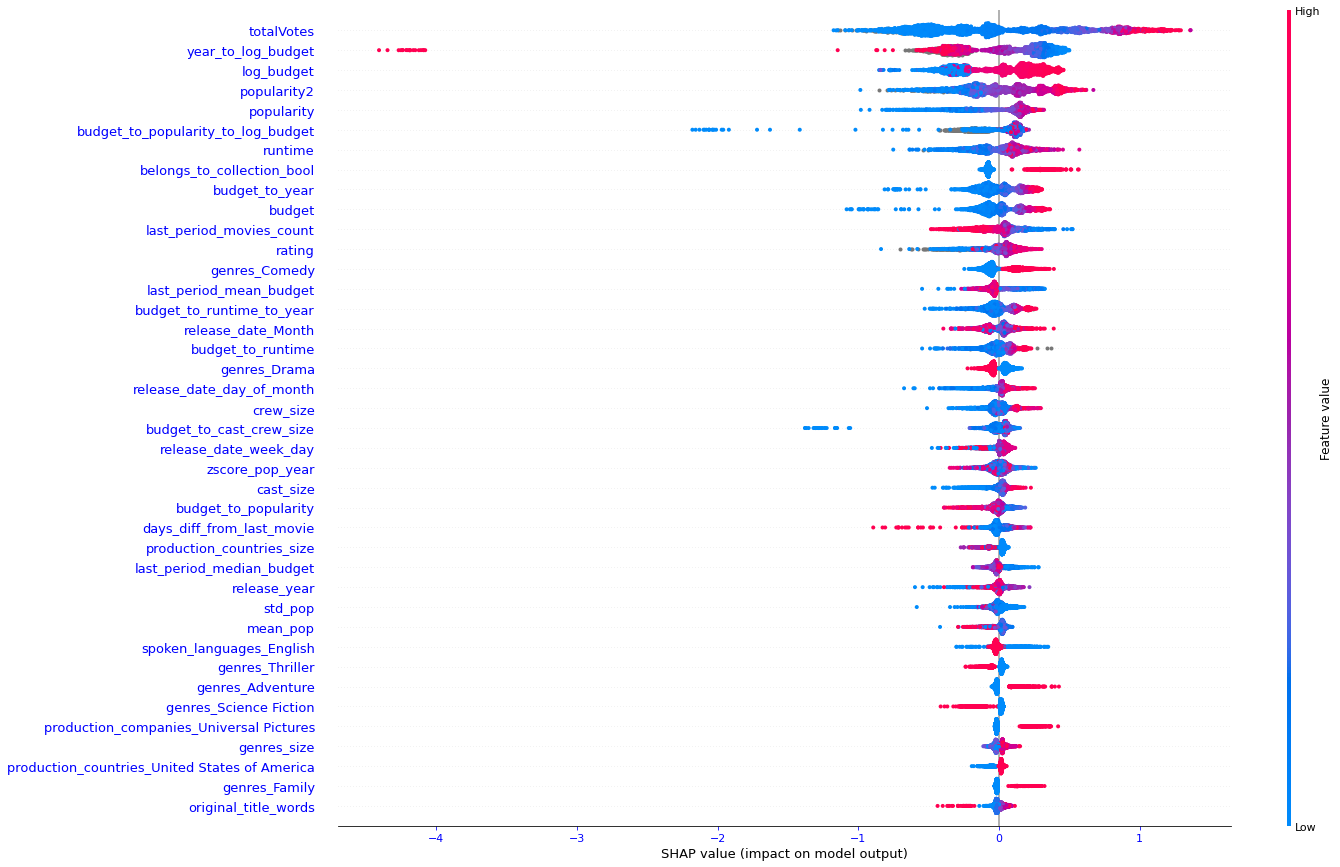

In [0]:
shap.initjs()
shap.summary_plot(sv, train.drop(['revenue','id', 'lgbfinal', 'xgbfinal', 'catfinal', 'PredictedLogRevenue'], axis=1), plot_type='dot', max_display=40, axis_color='b', plot_size=(20,15))

In [0]:
train.drop(['revenue','id', 'lgbfinal', 'xgbfinal', 'catfinal', 'PredictedLogRevenue'], axis=1).shape

(3000, 185)

In [0]:
l = []

for col in train.columns:
  if len(train[col].unique()) <= 3:
    l.append(col)

l


['AR',
 'AU',
 'BE',
 'BG',
 'CL',
 'CZ',
 'DE',
 'DK',
 'FR',
 'GB',
 'GR',
 'HK',
 'HU',
 'ID',
 'IE',
 'IL',
 'IS',
 'KW',
 'KZ',
 'Keywords_aftercreditsstinger',
 'Keywords_based on novel',
 'Keywords_duringcreditsstinger',
 'Keywords_independent film',
 'Keywords_love',
 'Keywords_murder',
 'Keywords_revenge',
 'Keywords_sex',
 'Keywords_violence',
 'Keywords_woman director',
 'LV',
 'MX',
 'NL',
 'NO',
 'PE',
 'PL',
 'RU',
 'SE',
 'SI',
 'TH',
 'TW',
 'cast_Bruce Willis',
 'cast_Liam Neeson',
 'cast_Matt Damon',
 'cast_Morgan Freeman',
 'cast_Nicolas Cage',
 'cast_Robert De Niro',
 'cast_Samuel L. Jackson',
 'cast_Steve Buscemi',
 'cast_Sylvester Stallone',
 'cast_Willem Dafoe',
 'crew_Avy Kaufman',
 'crew_Bob Weinstein',
 'crew_Deborah Aquila',
 'crew_Hans Zimmer',
 'crew_Harvey Weinstein',
 'crew_James Newton Howard',
 'crew_Mary Vernieu',
 'crew_Robert Rodriguez',
 'crew_Steven Spielberg',
 'crew_Tricia Wood',
 'genres_Action',
 'genres_Adventure',
 'genres_Animation',
 'genres_Comedy',
 'genres_Crime',
 'genres_Documentary',
 'genres_Drama',
 'genres_Family',
 'genres_Fantasy',
 'genres_Foreign',
 'genres_History',
 'genres_Horror',
 'genres_Music',
 'genres_Mystery',
 'genres_Romance',
 'genres_Science Fiction',
 'genres_Thriller',
 'genres_War',
 'genres_Western',
 'has_homepage',
 'overview_family',
 'overview_father',
 'overview_film',
 'overview_finds',
 'overview_friends',
 'overview_help',
 'overview_life',
 'overview_love',
 'overview_story',
 'overview_time',
 'overview_woman',
 'overview_world',
 'overview_years',
 'overview_young',
 'production_companies_Columbia Pictures',
 'production_companies_Columbia Pictures Corporation',
 'production_companies_Metro-Goldwyn-Mayer (MGM)',
 'production_companies_New Line Cinema',
 'production_companies_Paramount Pictures',
 'production_companies_Touchstone Pictures',
 'production_companies_Twentieth Century Fox Film Corporation',
 'production_companies_Universal Pictures',
 'production_companies_Walt Disney Pictures',
 'production_companies_Warner Bros.',
 'production_countries_Australia',
 'production_countries_Canada',
 'production_countries_France',
 'production_countries_Germany',
 'production_countries_India',
 'production_countries_Italy',
 'production_countries_Japan',
 'production_countries_Spain',
 'production_countries_United Kingdom',
 'production_countries_United States of America',
 'release_date_is_quarter_start',
 'spoken_languages_',
 'spoken_languages_Deutsch',
 'spoken_languages_English',
 'spoken_languages_Español',
 'spoken_languages_Français',
 'spoken_languages_Italiano',
 'spoken_languages_Pусский',
 'spoken_languages_हिन्दी',
 'spoken_languages_日本語',
 'spoken_languages_普通话',
 'belongs_to_collection_bool',
 'job_Producer_gender_0',
 'job_Producer_gender_1',
 'job_Producer_gender_2',
 'job_Director_gender_0',
 'job_Director_gender_1',
 'job_Director_gender_2',
 'order_0_gender_0',
 'order_0_gender_1',
 'order_0_gender_2',
 'order_1_gender_0',
 'order_1_gender_1',
 'order_1_gender_2']

In [0]:
from fastai.tabular import *

#traind = train.drop(l, axis=1).copy()
traind = train.drop(['id'], axis=1).copy()

dep_var = 'revenue'
cont_names = list(traind.drop(['revenue'], axis=1).columns.values)
procs = [FillMissing, Categorify, Normalize]

test = TabularList.from_df(traind.sample(2250).copy(), cont_names=cont_names, procs=procs)

data = (TabularList.from_df(traind, cont_names=cont_names, procs=procs, cat_names=[])
                           .split_by_idx(list(range(2250,3000)))
                           .label_from_df(cols=dep_var, label_cls = FloatList, log = True)
                           .add_test(test)
                           .databunch())

In [105]:
data.show_batch(rows=10)

AR_na,AT_na,AU_na,BE_na,BG_na,CA_na,CL_na,CZ_na,DE_na,DK_na,FI_na,FR_na,GB_na,GR_na,HK_na,HU_na,ID_na,IE_na,IL_na,IS_na,IT_na,KW_na,KZ_na,LV_na,MX_na,NL_na,NO_na,PE_na,PL_na,PT_na,RU_na,SE_na,SI_na,SK_na,TH_na,TR_na,TW_na,UA_na,US_na,last_period_mean_budget_na,last_period_mean_popularity_na,last_period_median_budget_na,last_period_median_popularity_na,last_period_movies_count_na,popularity2_na,rating_na,runtime_na,theatrical_na,theatrical_limited_na,totalVotes_na,budget_to_runtime_na,budget_to_popularity_to_log_budget_na,year_to_log_budget_na,budget_to_runtime_to_year_na,AR,AT,AU,BE,BG,CA,CL,CZ,DE,DK,FI,FR,GB,GR,HK,HU,ID,IE,IL,IS,IT,KW,KZ,Keywords_aftercreditsstinger,Keywords_based on novel,Keywords_duringcreditsstinger,Keywords_independent film,Keywords_love,Keywords_murder,Keywords_revenge,Keywords_sex,Keywords_size,Keywords_violence,Keywords_woman director,LV,MX,NL,NO,PE,PL,PT,RU,SE,SI,SK,TH,TR,TW,UA,US,budget,cast_Bruce Willis,cast_Liam Neeson,cast_Matt Damon,cast_Morgan Freeman,cast_Nicolas Cage,cast_Robert De Niro,cast_Samuel L. Jackson,cast_Steve Buscemi,cast_Sylvester Stallone,cast_Willem Dafoe,cast_size,crew_Avy Kaufman,crew_Bob Weinstein,crew_Deborah Aquila,crew_Hans Zimmer,crew_Harvey Weinstein,crew_James Newton Howard,crew_Mary Vernieu,crew_Robert Rodriguez,crew_Steven Spielberg,crew_Tricia Wood,crew_size,days_diff_from_last_movie,genres_Action,genres_Adventure,genres_Animation,genres_Comedy,genres_Crime,genres_Documentary,genres_Drama,genres_Family,genres_Fantasy,genres_Foreign,genres_History,genres_Horror,genres_Music,genres_Mystery,genres_Romance,genres_Science Fiction,genres_Thriller,genres_War,genres_Western,genres_size,has_homepage,last_period_mean_budget,last_period_mean_popularity,last_period_median_budget,last_period_median_popularity,last_period_movies_count,log_budget,mean_pop,overview_family,overview_father,overview_film,overview_finds,overview_friends,overview_help,overview_life,overview_love,overview_size,overview_story,overview_time,overview_woman,overview_world,overview_years,overview_young,popularity,popularity2,production_companies_Columbia Pictures,production_companies_Columbia Pictures Corporation,production_companies_Metro-Goldwyn-Mayer (MGM),production_companies_New Line Cinema,production_companies_Paramount Pictures,production_companies_Touchstone Pictures,production_companies_Twentieth Century Fox Film Corporation,production_companies_Universal Pictures,production_companies_Walt Disney Pictures,production_companies_Warner Bros.,production_companies_size,production_countries_Australia,production_countries_Canada,production_countries_France,production_countries_Germany,production_countries_India,production_countries_Italy,production_countries_Japan,production_countries_Spain,production_countries_United Kingdom,production_countries_United States of America,production_countries_size,rating,release_date_Month,release_date_day_of_month,release_date_is_quarter_start,release_date_week_day,release_year,runtime,spoken_languages_,spoken_languages_Deutsch,spoken_languages_English,spoken_languages_Español,spoken_languages_Français,spoken_languages_Italiano,spoken_languages_Pусский,spoken_languages_size,spoken_languages_हिन्दी,spoken_languages_日本語,spoken_languages_普通话,std_pop,theatrical,theatrical_limited,totalVotes,zscore_pop_year,budget_to_runtime,budget_to_cast_crew_size,budget_to_popularity,budget_to_year,budget_to_popularity_to_log_budget,year_to_log_budget,budget_to_runtime_to_year,belongs_to_collection_bool,original_title_words,job_Producer_gender_0,job_Producer_gender_1,job_Producer_gender_2,job_Director_gender_0,job_Director_gender_1,job_Director_gender_2,order_0_gender_0,order_0_gender_1,order_0_gender_2,order_1_gender_0,order_1_gender_1,order_1_gender_2,lgbfinal,xgbfinal,catfinal,PredictedLogRevenue,target
False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False

In [106]:
from fastai.callbacks import TrainingPhase, GeneralScheduler

learn = tabular_learner(data, layers=[200,100,50,30], metrics=root_mean_squared_error, use_bn=True)

def fit_sgd_warm(learn, n_cycles, lr, mom, cycle_len, cycle_mult):
    n = len(learn.data.train_dl)
    phases = [(TrainingPhase(n * (cycle_len * cycle_mult**i))
                 .schedule_hp('lr', lr, annealing_linear)
                 .schedule_hp('mom', mom)) for i in range(n_cycles)]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    if cycle_mult != 1:
        total_epochs = int(cycle_len * (1 - (cycle_mult)**n_cycles)/(1-cycle_mult)) 
    else: total_epochs = n_cycles * cycle_len
    learn.fit(total_epochs)

# path = untar_data(URLs.MNIST_SAMPLE)
# data = ImageDataBunch.from_folder(path)
# learn = Learner(data, simple_cnn((3,16,16,2)), metrics=accuracy)
fit_sgd_warm(learn, 10, 1e-3, 0.6, 1, 2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,268.886383,248.753189,15.768366,00:02
1,265.317078,247.101105,15.713362,00:02
2,260.811310,253.758041,15.919477,00:01
3,256.388489,246.000229,15.674952,00:02
4,248.941971,239.943924,15.479130,00:02
5,241.414795,233.529770,15.265332,00:02
6,235.431030,229.566727,15.133397,00:02
7,228.707214,208.528931,14.432942,00:02
8,217.385452,203.553207,14.241419,00:02
9,203.808441,172.525818,13.127563,00:02


In [2]:
learn

NameError: ignored